# üîπ Kurulum ve Ba≈ülangƒ±√ß Ayarlarƒ±

Bu b√∂l√ºmde eƒüitim i√ßin gerekli k√ºt√ºphaneleri y√ºkleyeceƒüiz ve Google Colab √ºzerinde
Drive baƒülantƒ±sƒ±nƒ± yapacaƒüƒ±z. B√∂ylece verilerimize Drive √ºzerinden eri≈üebileceƒüiz.  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time
import warnings
import os
import cv2
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import zipfile
import shutil

# üîπ Veri Seti Y√ºkleme ve ƒ∞nceleme

Bu b√∂l√ºmde veri setimizi Drive'dan okuyacaƒüƒ±z.  
- `pandas` kullanarak tabloyu y√ºkleyeceƒüiz.  
- ƒ∞lk satƒ±rlarƒ± g√∂r√ºnt√ºleyip yapƒ±yƒ± kontrol edeceƒüiz.  
- Eksik deƒüer var mƒ± diye hƒ±zlƒ±ca inceleme yapacaƒüƒ±z.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


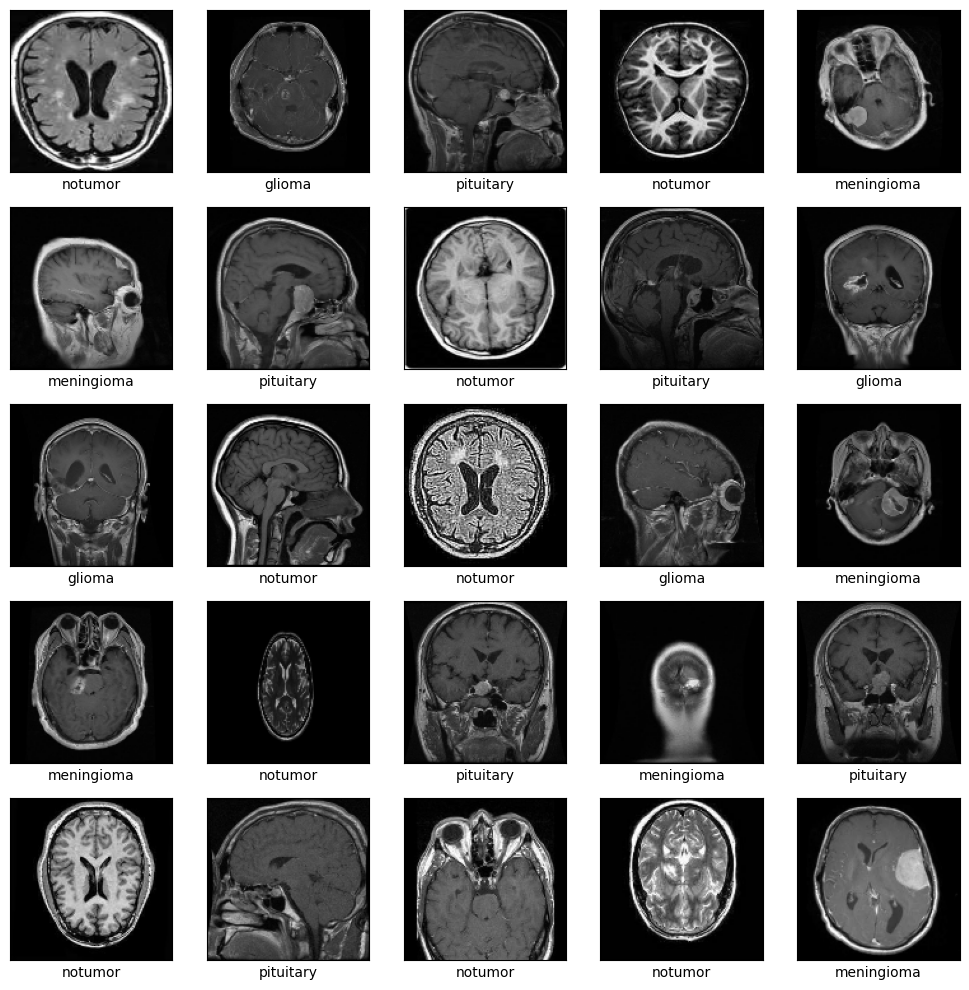

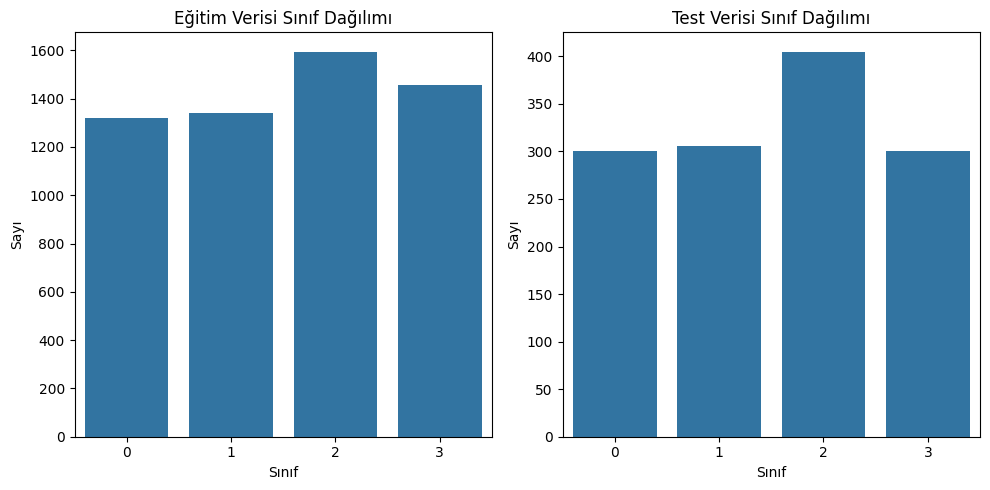

In [13]:
# Gerekli k√ºt√ºphaneler
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Drive'ƒ± baƒülama i≈ülemi
drive.mount('/content/drive')

# Klas√∂r yollarƒ±
train_dir = "/content/drive/MyDrive/kaggle/Training"
test_dir = "/content/drive/MyDrive/kaggle/Testing"

# Eƒüitim ve test veri setlerini y√ºkle
train_ds_original = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Sƒ±nƒ±f isimlerini kaydet
class_names = train_ds_original.class_names

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_original.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y))

# Performans i√ßin cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ƒ∞lk batch'ten 25 g√∂rseli g√∂rselle≈ütirelim
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

plt.figure(figsize=(10, 10))
for i in range(min(25, len(images))):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    plt.xlabel(class_names[labels[i]])
plt.tight_layout()
plt.show()

# Sƒ±nƒ±f daƒüƒ±lƒ±mƒ±nƒ± inceleyelim
all_labels = np.concatenate([y.numpy() for x, y in train_ds_original], axis=0)
all_test_labels = np.concatenate([y.numpy() for x, y in test_ds_original], axis=0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=all_labels.flatten())
plt.title('Eƒüitim Verisi Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
plt.xlabel('Sƒ±nƒ±f')
plt.ylabel('Sayƒ±')

plt.subplot(1, 2, 2)
sns.countplot(x=all_test_labels.flatten())
plt.title('Test Verisi Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±')
plt.xlabel('Sƒ±nƒ±f')
plt.ylabel('Sayƒ±')
plt.tight_layout()
plt.show()


# üîπ Veri Seti Hakkƒ±nda Genel Bilgiler

A≈üaƒüƒ±daki kod ile:
- Sƒ±nƒ±f isimlerini listeleyelim  
- Ka√ß √∂rnek olduƒüunu sayalƒ±m  
- G√∂rsellerden birka√ß √∂rnek g√∂rselle≈ütirelim


In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

print("Eƒüitim sƒ±nƒ±flarƒ±:", train_ds.class_names)
print("Eƒüitim batch sayƒ±sƒ±:", len(train_ds))
print("Test batch sayƒ±sƒ±:", len(test_ds))



Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Eƒüitim sƒ±nƒ±flarƒ±: ['glioma', 'meningioma', 'notumor', 'pituitary']
Eƒüitim batch sayƒ±sƒ±: 179
Test batch sayƒ±sƒ±: 41


# üîπ Veri √ñn ƒ∞≈üleme

Sinir aƒülarƒ± i√ßin g√∂rselleri normalize etmek (0‚Äì255 aralƒ±ƒüƒ±ndan 0‚Äì1 aralƒ±ƒüƒ±na) daha iyi sonu√ß verir.  
Bunun i√ßin `Rescaling` katmanƒ±nƒ± kullanacaƒüƒ±z.  

Ayrƒ±ca:
- `cache()` ‚Üí verileri belleƒüe alƒ±r, eƒüitim hƒ±zlanƒ±r.  
- `shuffle()` ‚Üí verileri karƒ±≈ütƒ±rƒ±r.  
- `prefetch()` ‚Üí GPU/CPU bo≈ü kalmadan veri hazƒ±rlanmasƒ±nƒ± saƒülar.  


In [15]:
# Normalizasyon katmanƒ±
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Eƒüitim verisine uygulama i≈ülemi
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Performans i√ßin cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# üîπ Kontrol: G√∂rsellerin Normalize Edildiƒüini G√∂relim

A≈üaƒüƒ±daki kod ile normalize edilmi≈ü bir batch'ten birka√ß √∂rnek g√∂rselle≈ütirelim.


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


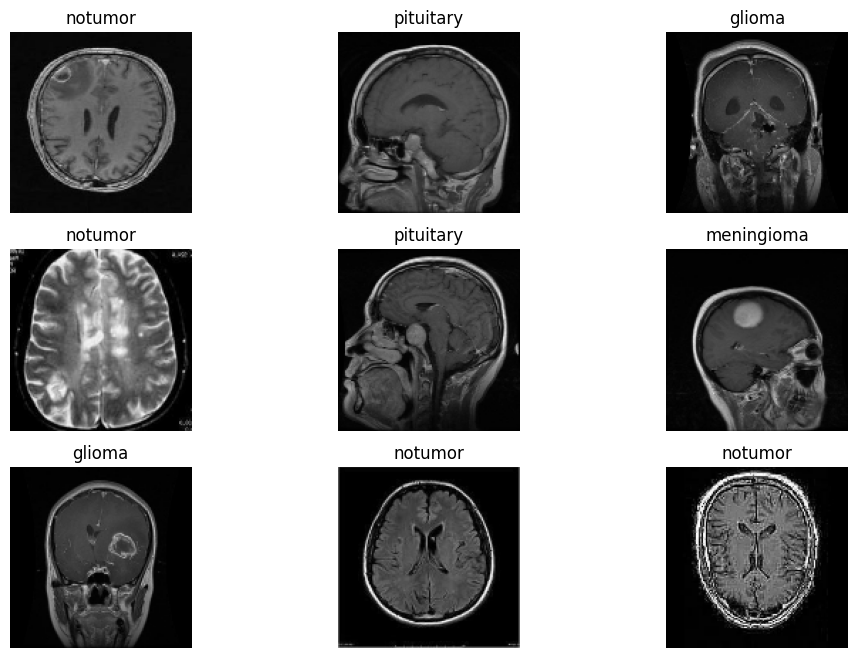

In [16]:
# Eƒüitim veri setini y√ºkle ve sƒ±nƒ±f isimlerini al
train_ds_original = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),
    batch_size=32
)
class_names = train_ds_original.class_names  # Sƒ±nƒ±f isimlerini kaydetme i≈ülemi

# Test veri setini y√ºkle
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_original.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y))

# Performans i√ßin cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize edilmi≈ü g√∂rselleri kontrol
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()



üîπ Veri Artƒ±rma (Data Augmentation)

Veri artƒ±rma, eƒüitim veri setindeki g√∂r√ºnt√ºleri rastgele d√∂n√º≈ü√ºmler uygulayarak √ße≈üitlendirme i≈ülemidir.  
Bu sayede model, farklƒ± a√ßƒ±lardan, boyutlardan veya ƒ±≈üƒ±k ko≈üullarƒ±ndan gelen √∂rnekleri g√∂rerek **daha iyi genelleme** yapabilir ve overfitting riski azalƒ±r.  

Yaygƒ±n veri artƒ±rma y√∂ntemleri:
- Yatay √ßevirme (Horizontal Flip)
- Hafif d√∂nme (Rotation)
- Yakƒ±nla≈ütƒ±rma/uzakla≈ütƒ±rma (Zoom)
- Kontrast deƒüi≈üimi (Contrast Adjustment)


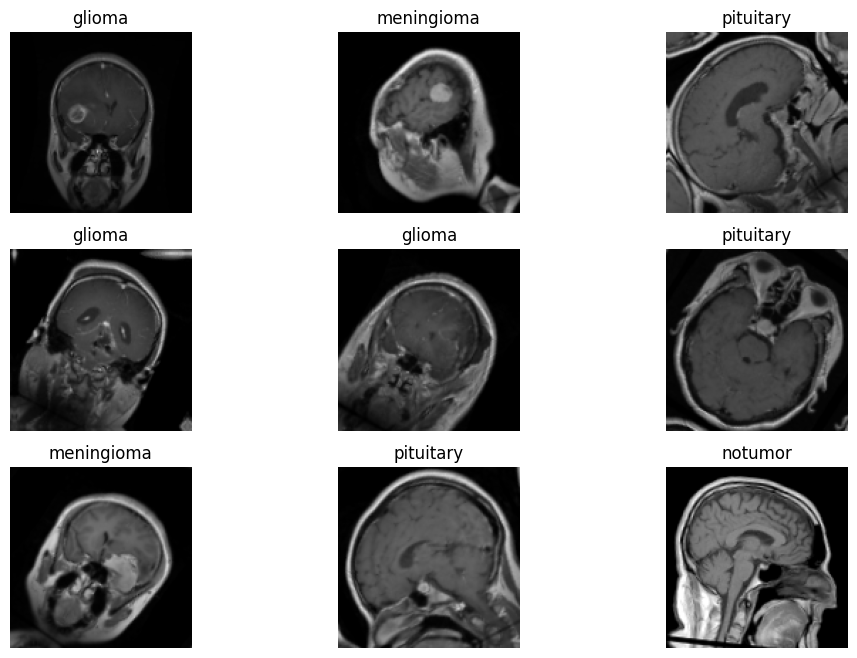

In [17]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artƒ±rma katmanƒ±
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),           # Yatay √ßevirme
    layers.RandomRotation(0.1),               # Hafif d√∂nme
    layers.RandomZoom(0.1),                   # Zoom
    layers.RandomContrast(0.1)                # Kontrast deƒüi≈üimi
])

# √ñrnek: ilk batch'e uygulayalƒ±m ve g√∂rselle≈ütirelim
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))  # Batch boyutu ekle
        plt.imshow(augmented_image[0].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()


üîπCNN Model A√ßƒ±klamasƒ±

- **Data Augmentation:** G√∂rselleri rastgele d√∂nd√ºrme, √ßevirme, zoom ve kontrast deƒüi≈üimi ile √ße≈üitlendirir.  
- **Conv2D + MaxPooling2D:** √ñzellik √ßƒ±karƒ±mƒ± ve boyut k√º√ß√ºltme.  
- **BatchNormalization:** Eƒüitim hƒ±zƒ±nƒ± artƒ±rƒ±r ve stabilite saƒülar.  
- **Dropout:** A≈üƒ±rƒ± √∂ƒürenmeyi √∂nler.  
- **Flatten + Dense:** √ñzellikleri sƒ±nƒ±flandƒ±rmaya d√∂n√º≈üt√ºr√ºr.  
- **Optimizer & Loss:** Adam optimizasyonu + sparse categorical crossentropy.  
- **Output:** Softmax ile sƒ±nƒ±f olasƒ±lƒ±klarƒ±.

In [18]:
# train_ds'den resim boyutlarƒ±nƒ± alma
for images, labels in train_ds.take(1):
    img_height, img_width = images.shape[1], images.shape[2]

input_shape = (img_height, img_width, 3)
num_classes = len(class_names)


In [19]:
from tensorflow.keras import layers, models, Input

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        Input(shape=input_shape),  # ƒ∞lk katmanda input_shape tanƒ±mlƒ±yoruz
        data_augmentation,          # Veri artƒ±rma katmanƒ±

        # 1. Convolution bloƒüu
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # 2. Convolution bloƒüu
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # 3. Convolution bloƒüu
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# √ñrnek kullanƒ±m
img_height = 128
img_width = 128
num_classes = len(class_names)

model = create_cnn_model((img_height, img_width, 3), num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ sequential_2 (Sequential)       ‚îÇ (None, 128, 128, 3)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_6 (Conv2D)               ‚îÇ (None, 128, 128, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_4           ‚îÇ (None, 128, 128, 32)   ‚îÇ           128 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_7 (Conv2D)               ‚îÇ (None, 128, 128, 32)   ‚îÇ         9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_3 (MaxPooling2D)  ‚îÇ (None, 64, 64, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 64, 64, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_8 (Conv2D)               ‚îÇ (None, 64, 64, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_5           ‚îÇ (None, 64, 64, 64)     ‚îÇ           256 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)               ‚îÇ (None, 64, 64, 64)     ‚îÇ        36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_4 (MaxPooling2D)  ‚îÇ (None, 32, 32, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)             ‚îÇ (None, 32, 32, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 4,483,364 (17.10 MB)

 Trainable params: 4,482,660 (17.10 MB)

 Non-trainable params: 704 (2.75 KB)

In [20]:
from tensorflow.keras.utils import image_dataset_from_directory

# Eƒüitim ve doƒürulama veri setlerini ayƒ±rma
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Test veri seti
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

# Normalizasyon
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


üîπCNN Model Eƒüitimi
Olu≈üturulan CNN modeli `train_ds` verisi ile eƒüitiliyor ve `val_ds` doƒürulama verisi ile performans izleniyor.


In [21]:
epochs = 16

history = model.fit(
    train_ds,         # eƒüitim veri seti
    validation_data=val_ds,  # doƒürulama veri seti
    epochs=epochs
)


Epoch 1/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 107ms/step - accuracy: 0.6242 - loss: 1.0267 - val_accuracy: 0.2566 - val_loss: 4.0924
Epoch 2/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 79ms/step - accuracy: 0.7400 - loss: 0.6815 - val_accuracy: 0.4667 - val_loss: 1.1326
Epoch 3/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 78ms/step - accuracy: 0.7806 - loss: 0.5891 - val_accuracy: 0.5000 - val_loss: 1.4037
Epoch 4/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 79ms/step - accuracy: 0.7999 - loss: 0.5232 - val_accuracy: 0.7434 - val_loss: 0.6432
Epoch 5/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 79ms/step - accuracy: 0.8387 - loss: 0.4435 - val_accuracy: 0.5604 - val_loss: 1.4026
Epoch 6/16
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 79ms/step - accuracy: 0.8650 - loss: 0.3865 - val_accuracy: 0.754

Model Doƒüruluƒüu ve Kayƒ±p Grafiƒüi

Model eƒüitildikten sonra eƒüitim ve doƒürulama doƒüruluƒüunu, ayrƒ±ca kayƒ±p deƒüerlerini g√∂rselle≈ütirmek i√ßin kullanƒ±lan grafikler:

Sol grafikte: Eƒüitim ve doƒürulama doƒüruluƒüu

Saƒü grafikte: Eƒüitim ve doƒürulama kaybƒ±

Bu g√∂rselle≈ütirme, modelin a≈üƒ±rƒ± √∂ƒürenme (overfitting) yapƒ±p yapmadƒ±ƒüƒ±nƒ± ve genel performansƒ±nƒ± hƒ±zlƒ±ca deƒüerlendirmeye yardƒ±mcƒ± olur.

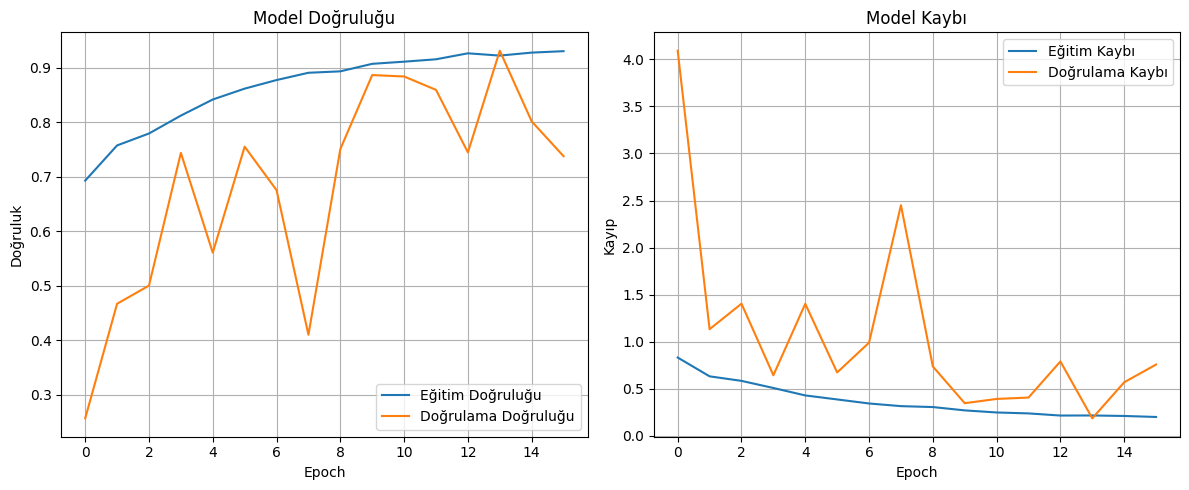

In [23]:
import matplotlib.pyplot as plt
# √ñrnek: history = model.fit(train_ds, validation_data=val_ds, epochs=20)

# Doƒüruluk grafiƒüi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eƒüitim Doƒüruluƒüu')
plt.plot(history.history['val_accuracy'], label='Doƒürulama Doƒüruluƒüu')
plt.title('Model Doƒüruluƒüu')
plt.xlabel('Epoch')
plt.ylabel('Doƒüruluk')
plt.legend()
plt.grid(True)

# Kayƒ±p grafiƒüi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eƒüitim Kaybƒ±')
plt.plot(history.history['val_loss'], label='Doƒürulama Kaybƒ±')
plt.title('Model Kaybƒ±')
plt.xlabel('Epoch')
plt.ylabel('Kayƒ±p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Model Deƒüerlendirme A≈üamasƒ±

41/41 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 117ms/step - accuracy: 0.7580 - loss: 0.7656
Test Kaybƒ±: 0.7551
Test Doƒüruluƒüu: 0.7536
41/41 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step

Sƒ±nƒ±flandƒ±rma Raporu:
              precision    recall  f1-score   support

      glioma       0.60      0.99      0.75       300
  meningioma       0.83      0.21      0.34       306
     notumor       0.80      0.98      0.88       405
   pituitary       0.95      0.76      0.84       300

    accuracy                           0.75      1311
   macro avg       0.80      0.74      0.70      1311
weighted avg       0.80      0.75      0.72      1311



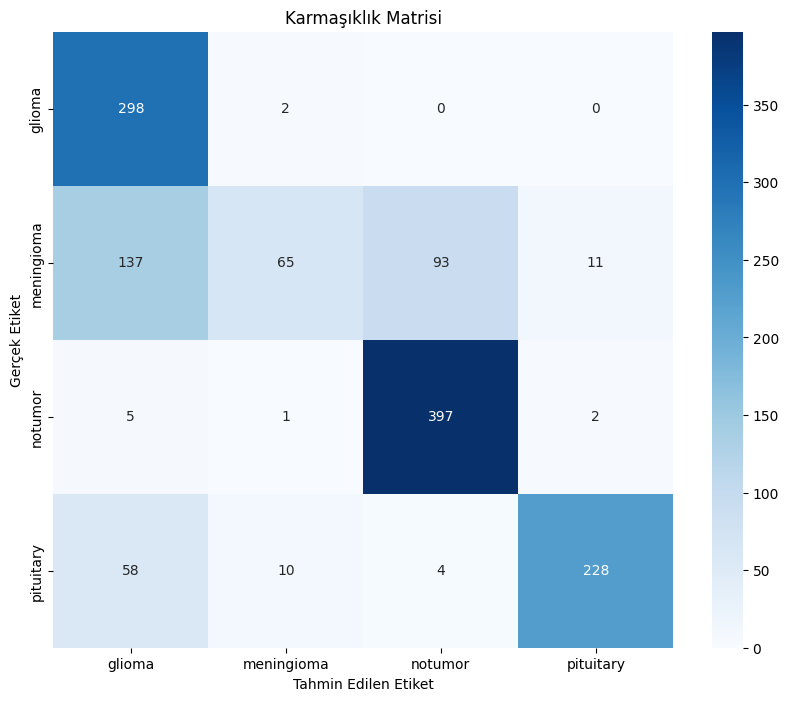

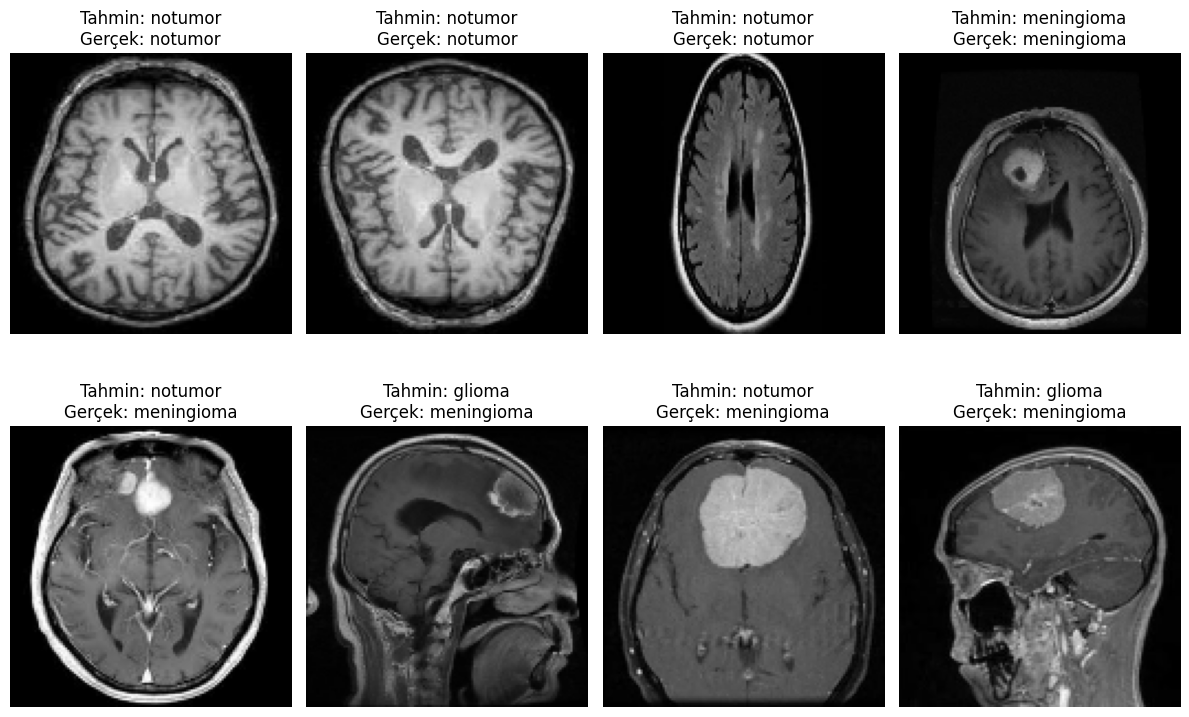

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Test veri seti √ºzerinde modeli deƒüerlendirelim
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Kaybƒ±: {test_loss:.4f}")
print(f"Test Doƒüruluƒüu: {test_accuracy:.4f}")

# Tahminlerde bulunalƒ±m
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ger√ßek etiketleri alalƒ±m
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Sƒ±nƒ±flandƒ±rma raporu
print("\nSƒ±nƒ±flandƒ±rma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karma≈üƒ±klƒ±k matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karma≈üƒ±klƒ±k Matrisi')
plt.ylabel('Ger√ßek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Bazƒ± doƒüru ve yanlƒ±≈ü tahmin √∂rneklerini g√∂rselle≈ütirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doƒüru tahmin √∂rnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(np.array(list(test_ds.unbatch().map(lambda x, y: x))[correct]))
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGer√ßek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlƒ±≈ü tahmin √∂rnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(np.array(list(test_ds.unbatch().map(lambda x, y: x))[incorrect]))
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGer√ßek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
√ñnceden Eƒüitilmi≈ü Hazƒ±r Bir Modelle Eƒüitim

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

# √ñnceden eƒüitilmi≈ü VGG16 modelini kullanalƒ±m
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)  # senin veri boyutuna g√∂re
)

# Temel modelin katmanlarƒ±nƒ± donduralƒ±m
for layer in base_model.layers:
    layer.trainable = False

# Yeni bir model olu≈üturalƒ±m
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # sƒ±nƒ±f sayƒ±sƒ± senin veri setine g√∂re
])

# Modeli derleyelim
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()

# Modeli eƒüitelim
history_transfer = transfer_model.fit(
    train_ds,          # eƒüitim veri seti
    validation_data=test_ds,  # test/validation veri seti
    epochs=20,
    verbose=1
)

# Transfer learning modelini deƒüerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(test_ds, verbose=1)
print(f"Transfer Learning Test Doƒüruluƒüu: {test_accuracy_transfer:.4f}")


58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 0us/step


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ vgg16 (Functional)              ‚îÇ (None, 4, 4, 512)      ‚îÇ    14,714,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 512)            ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       131,328 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 4)              ‚îÇ         1,028 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 30s 157ms/step - accuracy: 0.5656 - loss: 1.0142 - val_accuracy: 0.7811 - val_loss: 0.6372
Epoch 2/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.8018 - loss: 0.5477 - val_accuracy: 0.8055 - val_loss: 0.5693
Epoch 3/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 74ms/step - accuracy: 0.8440 - loss: 0.4336 - val_accuracy: 0.8207 - val_loss: 0.4939
Epoch 4/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.8658 - loss: 0.3843 - val_accuracy: 0.8200 - val_loss: 0.4851
Epoch 5/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 76ms/step - accuracy: 0.8545 - loss: 0.3881 - val_accuracy: 0.8330 - val_loss: 0.4324
Epoch 6/20
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 76ms/step - accuracy: 0.8629 - loss: 0.3687 - val_accuracy: 0.852

Modellerin Kar≈üƒ±la≈ütƒ±rƒ±lmasƒ±

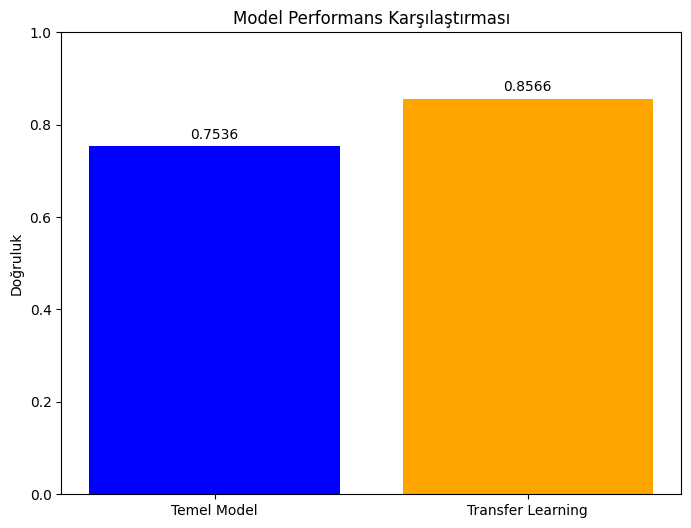

In [38]:
import matplotlib.pyplot as plt

# Model performanslarƒ±nƒ± kar≈üƒ±la≈ütƒ±ralƒ±m
models = ['Temel Model', 'Transfer Learning']
accuracies = [test_accuracy, test_accuracy_transfer]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.ylabel('Doƒüruluk')
plt.ylim(0, 1)

# √áubuklarƒ±n √ºzerine doƒüruluk deƒüerlerini yazalƒ±m
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()


Model ƒ∞yile≈ütirme Teknikleri


Adam optimizer ile eƒüitim...
Epoch 1/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 93ms/step - accuracy: 0.5495 - loss: 1.0500 - val_accuracy: 0.7307 - val_loss: 0.7015
Epoch 2/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 73ms/step - accuracy: 0.7983 - loss: 0.5523 - val_accuracy: 0.7963 - val_loss: 0.5821
Epoch 3/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 73ms/step - accuracy: 0.8291 - loss: 0.4690 - val_accuracy: 0.8192 - val_loss: 0.5111
Epoch 4/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.8417 - loss: 0.4178 - val_accuracy: 0.8085 - val_loss: 0.4920
Epoch 5/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 75ms/step - accuracy: 0.8481 - loss: 0.3907 - val_accuracy: 0.8314 - val_loss: 0.4458
Adam Test Doƒüruluƒüu: 0.8314

RMSprop optimizer ile eƒüitim...
Epoch 1/5
143/143 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

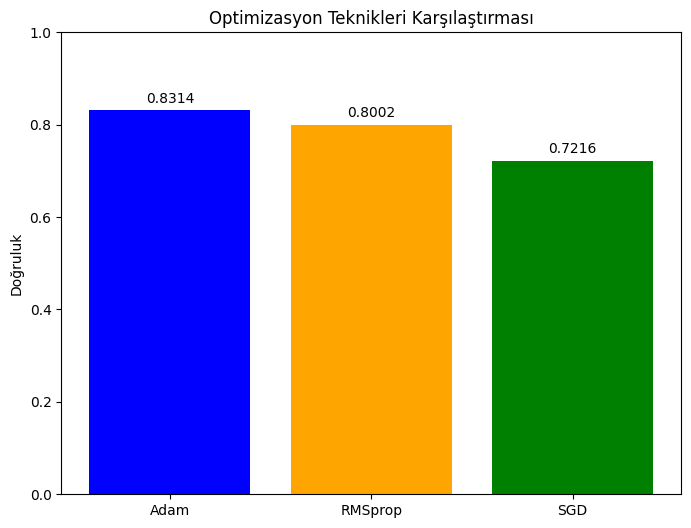

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

# Optimizasyon teknikleri
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer ile eƒüitim...")

    # Transfer learning modeli olu≈ütur
    base_model = keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )
    base_model.trainable = False

    transfer_model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    transfer_model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Modeli eƒüit
    history = transfer_model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=5,
        verbose=1
    )

    # Test doƒüruluƒüu
    test_loss, test_acc = transfer_model.evaluate(test_ds, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doƒüruluƒüu: {test_acc:.4f}")

# Optimizasyon tekniklerini kar≈üƒ±la≈ütƒ±ralƒ±m
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.title('Optimizasyon Teknikleri Kar≈üƒ±la≈ütƒ±rmasƒ±')
plt.ylabel('Doƒüruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()


Modelin Son Deƒüerlendirmesi

In [41]:
print("=" * 50)
print("Brain Tumor MRI Sonu√ßlarƒ±")
print("=" * 50)
print(f"Temel CNN Model Doƒüruluƒüu: {test_accuracy:.4f}")  # temel modelden gelen doƒüruluk
print(f"Transfer Learning Model Doƒüruluƒüu: {test_accuracy_transfer:.4f}")  # transfer learning doƒüruluk
best_optimizer = max(results, key=results.get)
best_acc = results[best_optimizer]
print(f"En iyi optimizer: {best_optimizer} ({best_acc:.4f})")  # optimizasyon kar≈üƒ±la≈ütƒ±rmasƒ±
print("=" * 50)


Brain Tumor MRI Sonu√ßlarƒ±
Temel CNN Model Doƒüruluƒüu: 0.7536
Transfer Learning Model Doƒüruluƒüu: 0.8566
En iyi optimizer: Adam (0.8314)
